In [30]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
%matplotlib inline

In [2]:
data = pd.read_csv('Time_series/sp500_index.csv')
data.head()

,Date,S&P500
0,2014-10-17,1886.76
1,2014-10-20,1904.01
2,2014-10-21,1941.28
3,2014-10-22,1927.11
4,2014-10-23,1950.82


In [3]:
data['Date'] = pd.to_datetime(data['Date'])

#data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2024)]

In [4]:
print(data.shape)
print(data.dtypes)

(2516, 2)
Date      datetime64[ns]
S&P500           float64
dtype: object


In [5]:
data.isnull().values.any()

False

In [6]:
data.describe()

,Date,S&P500
count,2516,2516.000000
mean,2019-10-17 07:17:50.270270208,3275.335537
min,2014-10-17 00:00:00,1829.080000
25%,2017-04-18 18:00:00,2373.470000
50%,2019-10-16 12:00:00,2945.495000
75%,2022-04-15 00:00:00,4154.607500
max,2024-10-16 00:00:00,5859.850000
std,NaN,1032.744674


### Exploratory Data Analysis

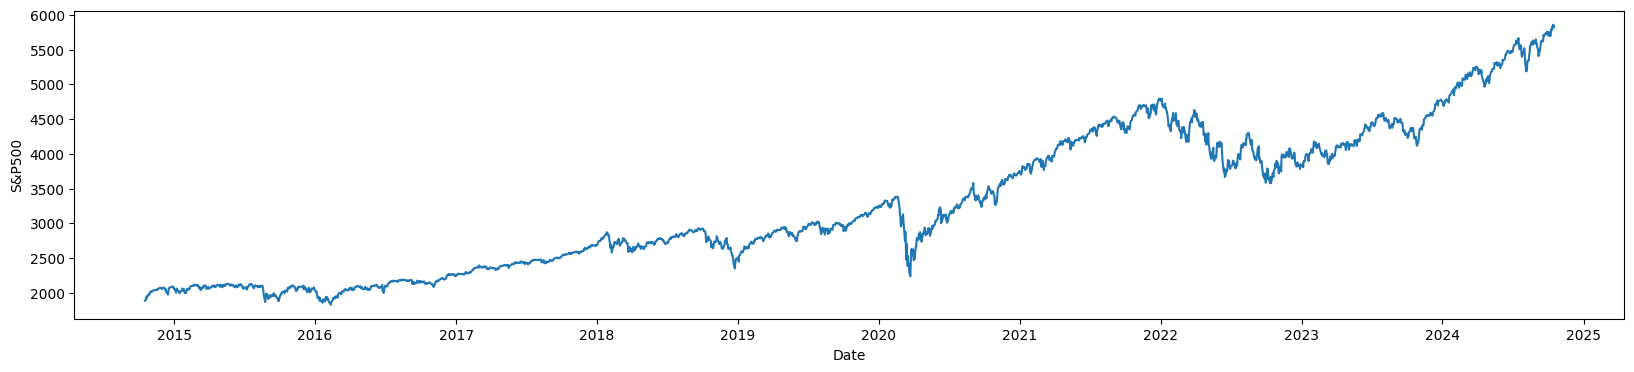

In [7]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])
plt.show()

Abbiamo osservato che nel 2020 c'è un forte picco verso il basso che altera la tendenza nei dati. Analizziamo successivamente in dettaglio cosa succede

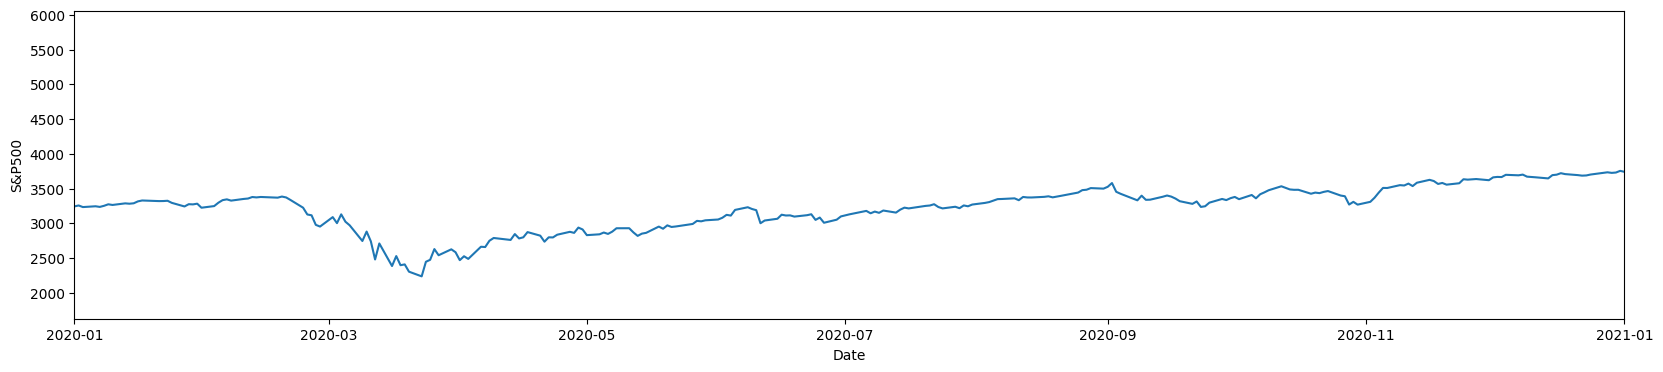

In [8]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

Si può notare che il grande picco verso il basso si può ricollegare all'inizio del COVID, nei mesi di marzo aprile 2020. Successivamente si nota una graduale ripresa

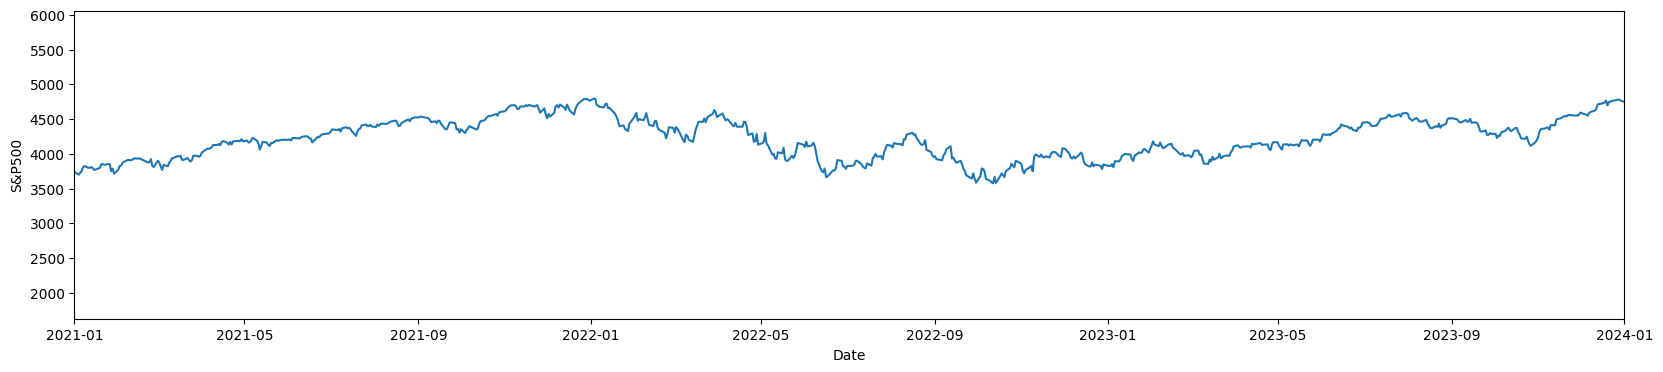

In [9]:
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2024,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

un altro momento di picco verso il basso si ha ad inizio 2022 fino al 2023, ricollegabile alla difficile situazione geopolitica tra russia e ucraina

In [10]:
# Rimuovi i dati dal 2020-01-01 al 2020-05-31
#data_filter = data[~((data['Date'] >= '2020-01-01') & (data['Date'] <= '2020-05-31'))]

# Rimuovi dati da anni precedenti al 2022 o successivi al 2023
#data_new = data_filter[~((data_filter['Date'] >= '2022-01-01') & (data_filter['Date'] <= '2023-01-01'))]

data_new = data

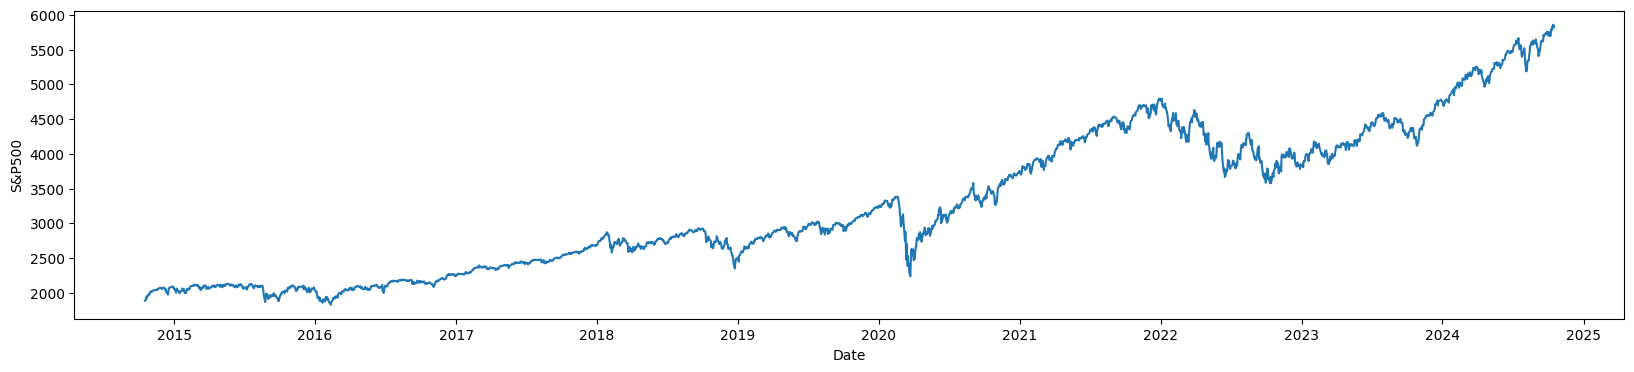

In [11]:
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data_new['Date'], data_new['S&P500'])
plt.show()

## Forecasting

### Stationarity

In [12]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

In [13]:
test_stationarity(data_new['S&P500'])

ADF statistic: 0.8475564637156415
P-value: 0.9923662995903405


Questo valore è molto alto, vicino a 1.
Un valore p così elevato indica che non hai evidenza sufficiente per rifiutare l'ipotesi nulla (H₀), che afferma che la serie non è stazionaria. Quindi serie non stazionaria (media, varianza o covarianza variano nel tempo). Per rednerla stazonaria applicando le differenze ecc.

In [14]:
(data_new['S&P500'] - data_new['S&P500'].shift(1)).head()

0      NaN
1    17.25
2    37.27
3   -14.17
4    23.71
Name: S&P500, dtype: float64

In [15]:
data_new['S&P500'].diff().head()

0      NaN
1    17.25
2    37.27
3   -14.17
4    23.71
Name: S&P500, dtype: float64

In [16]:
test_stationarity(data_new['S&P500'].diff().dropna())

ADF statistic: -10.277873153330367
P-value: 3.847995921935779e-18


Questo valore di ADF è ora molto negativo, il che suggerisce una forte evidenza contro l'ipotesi nulla (H₀). Un p-value così basso conferma che possiamo rifiutare l'ipotesi nulla (H₀) con grande confidenza. Concludiamo quindi che la serie è stazionaria dopo la differenziazione.

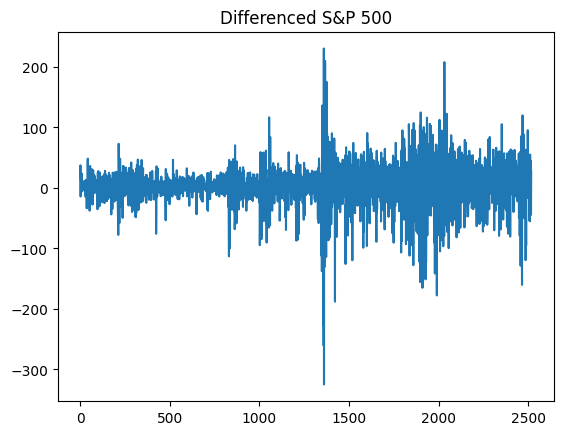

In [17]:
import matplotlib.pyplot as plt
data_new['S&P500'].diff().dropna().plot(title="Differenced S&P 500")
plt.show()

### ACF and PACF graphs

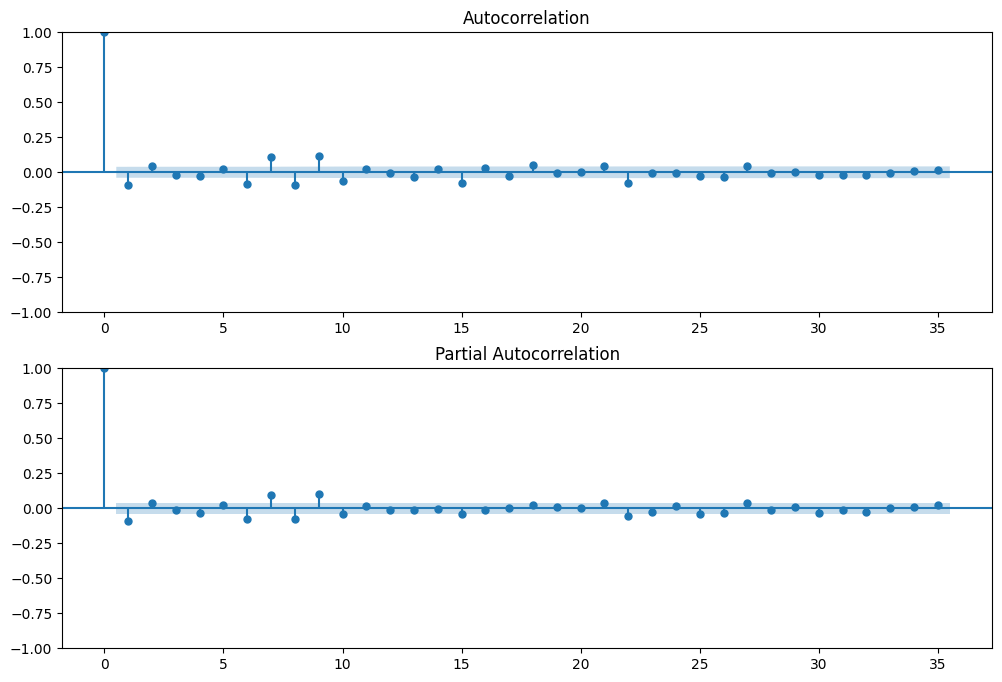

In [18]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_new['S&P500'].diff()[1:],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_new['S&P500'].diff()[1:], ax=ax2)

Primo valore 1 in entrambi perché Il primo lag (ritardo 0) di entrambe le funzioni mostra la correlazione della serie con sé stessa, che è sempre 1 (ovvero perfettamente correlata). Tutti gli altri valori sono prossimi allo zero, Questo comportamento suggerisce che la serie differenziata è quasi rumore bianco:
Un rumore bianco non ha una struttura prevedibile, il che significa che i valori futuri non dipendono linearmente dai valori passati. Possiamo provare quindi un ARIMA con d=1, p=0 (AR) e q=0 (MA).
- (0,1,0) 
- Auto_Arima (2,1,2)

### Fitting Model

In [29]:
# Modello ARIMA
model = ARIMA(data_new['S&P500'], order=(0, 1, 0))
results_base = model.fit()

# Sommario del modello
print(results_base.summary())

                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 2516
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -12637.402
Date:                Sat, 16 Nov 2024   AIC                          25276.804
Time:                        16:09:46   BIC                          25282.634
Sample:                             0   HQIC                         25278.920
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1355.2583     17.482     77.522      0.000    1320.994    1389.523
Ljung-Box (L1) (Q):                  19.33   Jarque-Bera (JB):              6377.98
Prob(Q):                              0.00   Pr

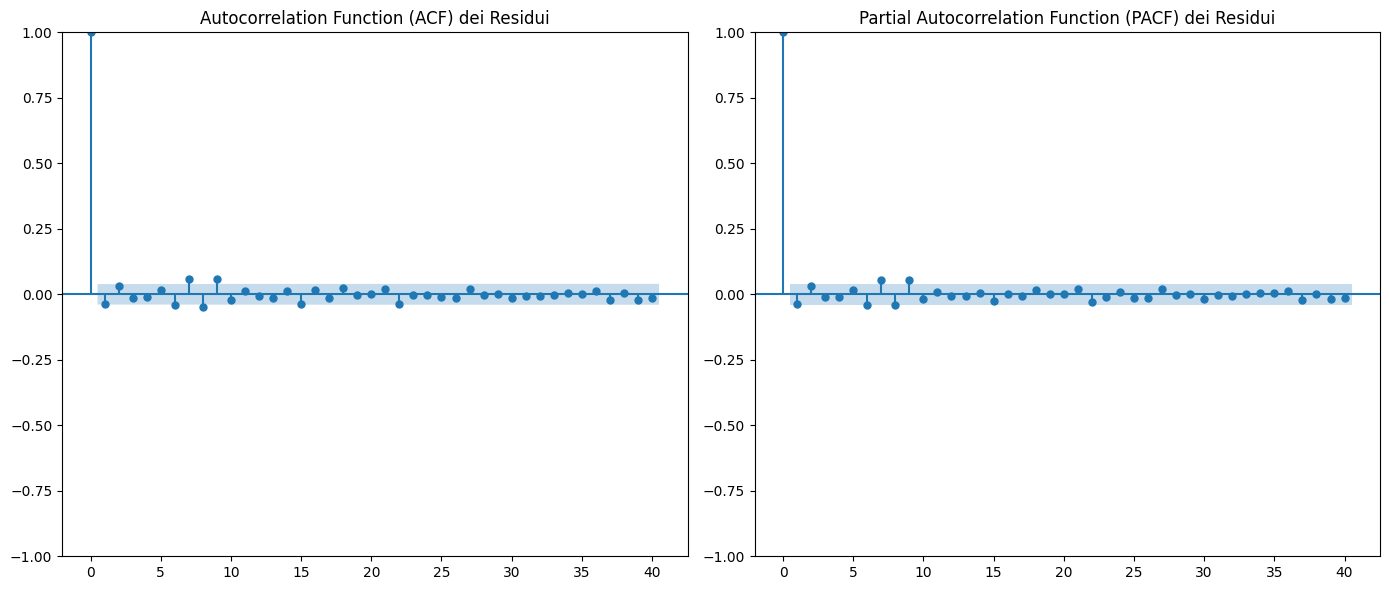

In [32]:
# Previsione dei residui
residuals = results_base.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

### Test di Ljun-Box sui residui

In [33]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
      lb_stat  lb_pvalue
10  36.117341   0.000080
20  43.268863   0.001883
30  50.049849   0.012255


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
m = 12
model = auto_arima(data_new['S&P500'], seasonal=False, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25187.856, Time=11.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25274.209, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25256.833, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25258.307, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25276.804, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25256.793, Time=6.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25256.982, Time=4.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25189.275, Time=13.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25258.525, Time=13.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25255.801, Time=2.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25257.124, Time=9.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25257.642, Time=8.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25190.656, Time=17.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=25191.063, Time=5.36 sec

Best model:  A

                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 2516
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12590.532
Date:                Sat, 16 Nov 2024   AIC                          25191.063
Time:                        15:55:21   BIC                          25220.213
Sample:                             0   HQIC                         25201.643
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7591      0.021    -84.630      0.000      -1.800      -1.718
ar.L2         -0.8770      0.020    -44.559      0.000      -0.916      -0.838
ma.L1          1.6918      0.026     65.900      0.0

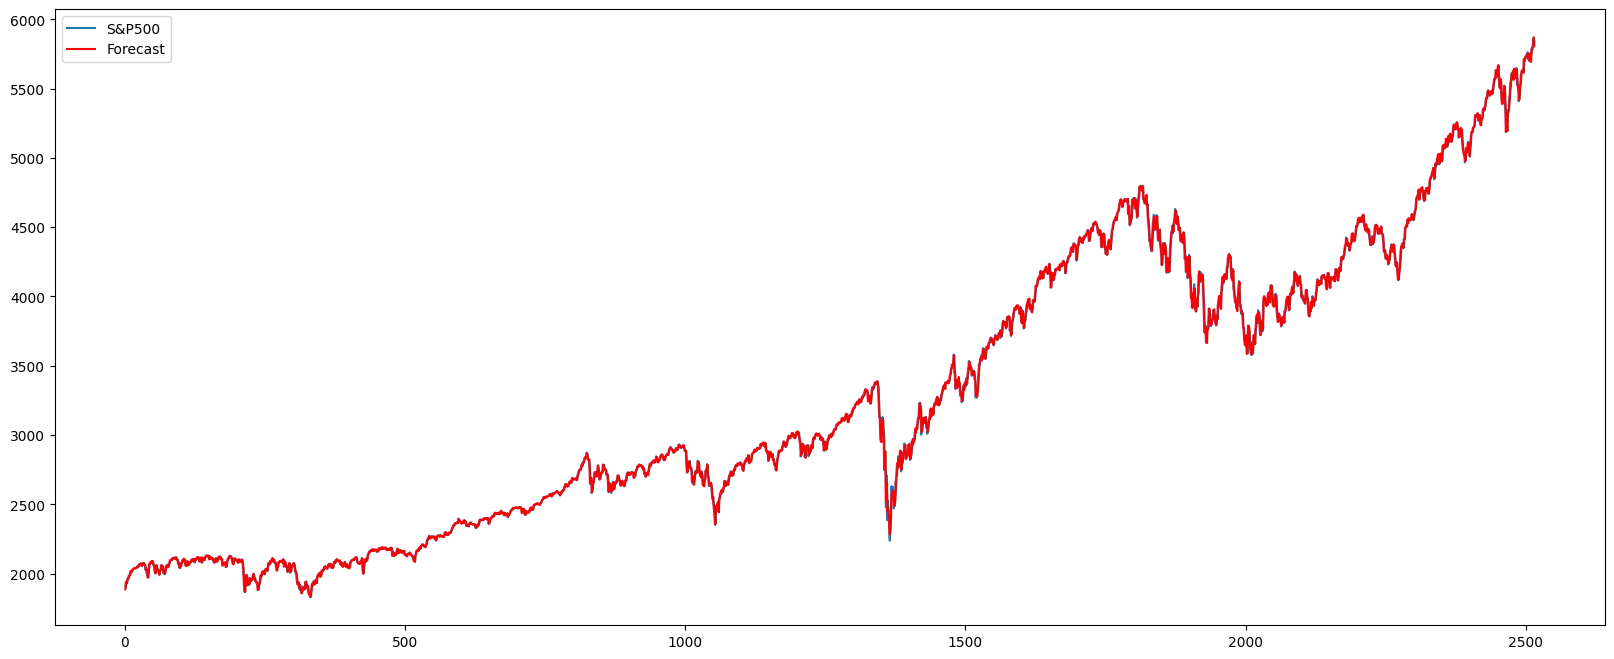

In [20]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(data_new['S&P500'], order=(2,1,2)) 
ax = plt.gca()
results = model.fit() 
plt.plot(data_new['S&P500'][1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

print(results.summary())

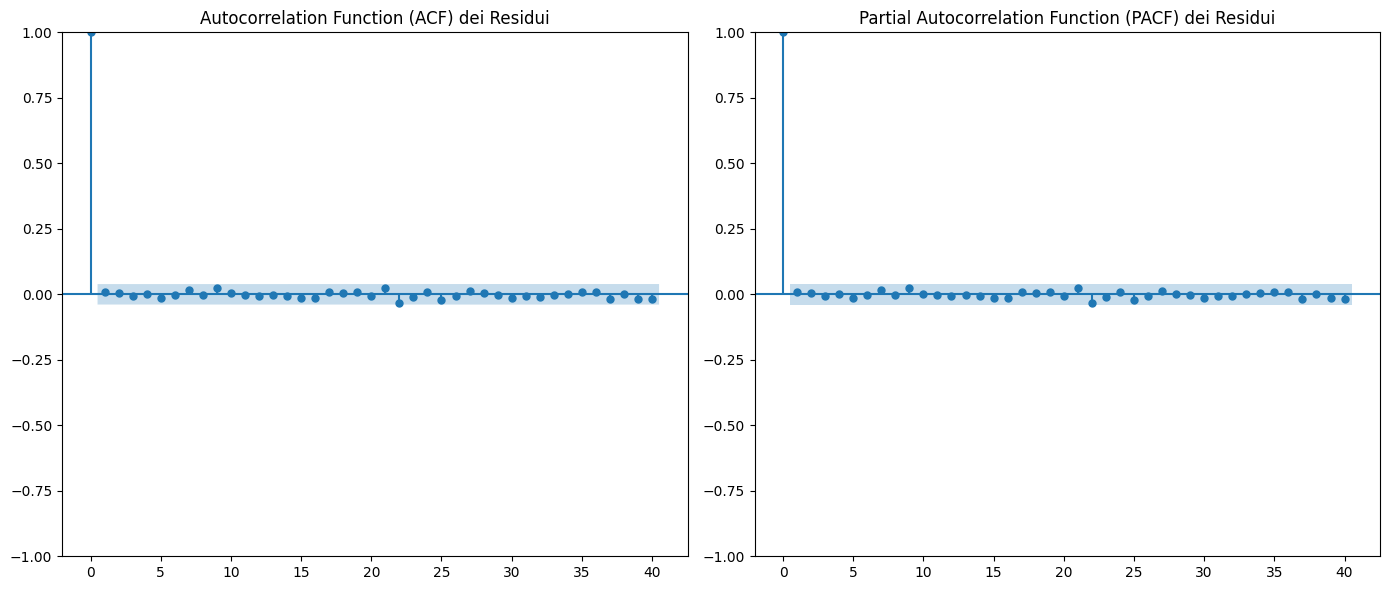

In [27]:
# Previsione dei residui
residuals = results.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

### Test di Ljung-Box

In [28]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
      lb_stat  lb_pvalue
10   2.970159   0.982118
20   4.775509   0.999806
30  11.602412   0.998988


I valori di p-value sopra la soglia di 0.05 indicano che i residui non mostrano correlazioni significative e inoltre indica che il modello ha catturato le principali dinamiche della serie temporale. In linea con i risultati di ACf e PACF vicini allo zero.

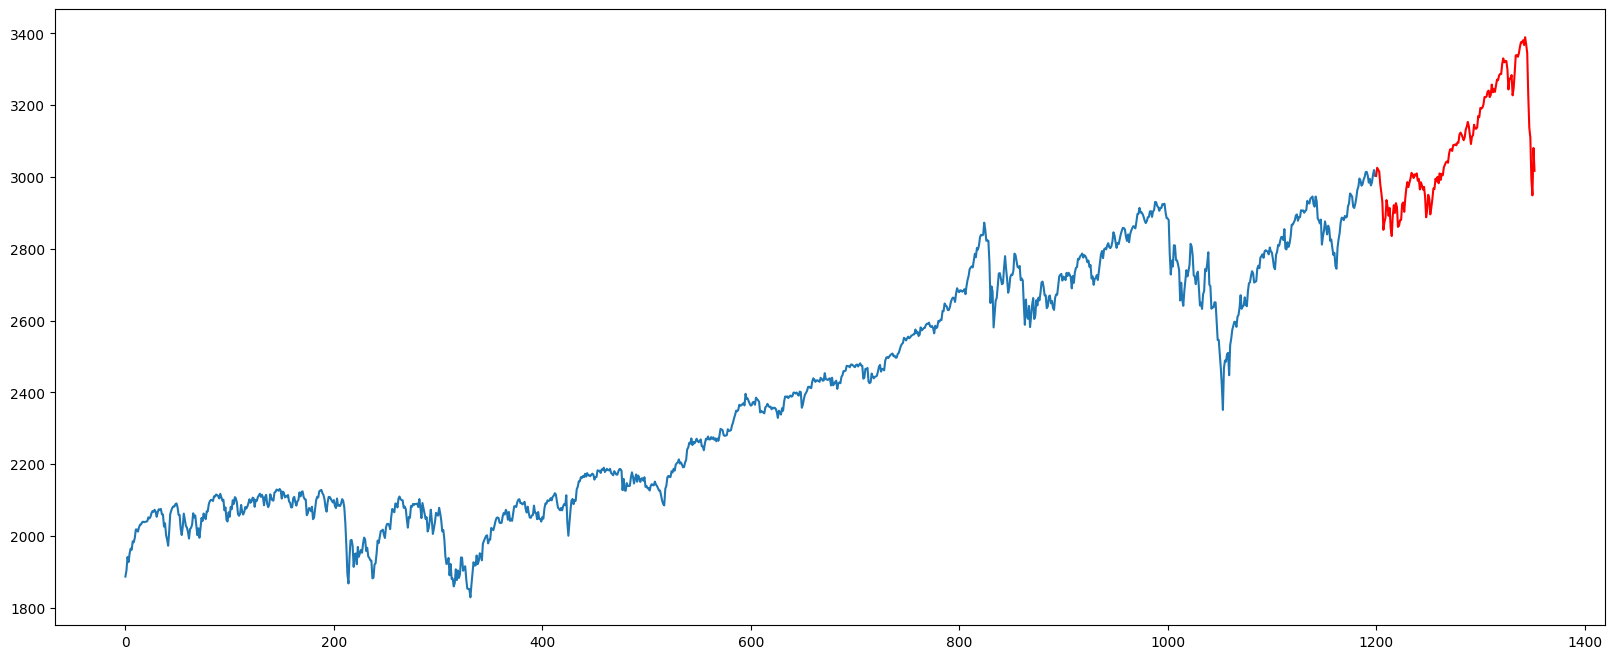

In [21]:
fig = plt.figure(figsize=(20,8))
num_points = len(data_new['S&P500'])
x = results.predict(start=(1200), end=(1352), dynamic=False)

plt.plot(data_new['S&P500'][:1200])
plt.plot(x, color='r')